In [86]:
# processing
import pandas as pd
import numpy as np
from os import path
import glob
import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from scipy.stats import mode
from scipy.stats import skew
from scipy.stats import kurtosis
from numpy import linalg
from sklearn.ensemble import AdaBoostRegressor
import math
import random
from sklearn.decomposition import PCA
import itertools
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

# graphs
from scipy.stats import boxcox

from matplotlib import pyplot as plt

# models
from sklearn.cluster import KMeans

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz


from sklearn.linear_model import LogisticRegression

import pickle


# accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score


#display
from IPython.display import Markdown, display
from __future__ import print_function
def printmd(string):
    display(Markdown(string))
np.set_printoptions(threshold=np.nan)
pd.set_option("mode.use_inf_as_na", True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)

# <font size = 50 color = blue> Downloading Dataset and Preliminary Data Cleaning

In [157]:
"""
folder_1 = 'eclipse-workspace/ECALC/full'
paths_1 = glob.glob(folder_1 + "/*.csv")
dfs = [pd.read_csv(f,error_bad_lines=False,warn_bad_lines=False,dtype=np.float64,na_values='-') for f in paths_1]
folder_2 = 'eclipse-workspace/ECALC/good'
paths_2 = glob.glob(folder_2 + "/*.csv")
#for f in paths_2:
 #   print(f)
  #  dfs.append(pd.read_csv(f,error_bad_lines=False,warn_bad_lines=False,dtype=np.float64,na_values='-') )
dfs.extend([pd.read_csv(f,error_bad_lines=False,warn_bad_lines=False,dtype=np.float64,na_values='-') 
            for f in paths_2])
file_names = [f for f in paths_1]
file_names.extend([f for f in paths_2])
for i,df in enumerate(dfs):
    if (any([True for a in df['inBS'] if a > 40])):
        print(file_names[i])

data_full = pd.concat(dfs)

printmd(("## Initial \# of Data Points: %d" %(len(data_full.index),)))
"""

## Initial \# of Data Points: 940516

In [ ]:
"""
data_full.dropna(subset=['outPThrust','outBLoad','rpm 1'],how='all',inplace=True)
data_full.drop(columns=['outBWeight','outBWeightOz','outPFlightThrust','outPPitchSpeed','outTotPowerWeight',
              'outTotTorque','Unnamed: 289','Unnamed: 294'],inplace=True)
for i in range(1,15):
    data_full.drop(columns=['Thrust (g) '+str(i),'Spec. Thrust (g/W) '+str(i),'Pitch Speed (km/h) '+str(i),
                'Speed (level) (km/h) '+str(i)],inplace=True)
print('')
printmd(("## \# of Useful Data Points: %d" %(len(data_full.index),)))
printmd('## Useful columns:')
print(data_full.columns)
"""

In [160]:
data_full.to_csv("eCalc Data.csv",index=False)

In [161]:
"""
# data imputation. I imputate based on what I know about how I collected data.
data_full['Ptwist'].fillna(0, inplace=True)
# data_full['inGWeight'].fillna(___, inplace=True)
data_full['inMPoles'].fillna(12, inplace=True)
data_full['inGWingArea'].fillna(50, inplace=True)
data_full['inGDragCd'].fillna(0.05, inplace=True)
data_full['inPConst'].fillna(1.2, inplace=True)
data_full['inTConst'].fillna(1.0, inplace=True)
data_full['inBVcell'].fillna(1.2, inplace=True)
data_full['inBP'].fillna(1, inplace=True)

data_full.to_csv("eCalc Data.csv",index=False)
"""

In [4]:
data_full = pd.read_csv("eCalc Data.csv")
data_full = data_full.astype(np.float64)

In [304]:
# Now, fill the remaining values (which are all outputs) with the average value. this will be helpful for 
# a lot of analysis. However, we still keep the dataframe with these values kept blank (NaN), since 
# imputating average values can make our data seem less spread out than it really is.

data_filled = data_full.copy()
for col_name in data_filled.columns:
    data_filled[col_name] = data_filled[col_name].fillna(np.nanmean(data_filled[col_name]))

# some data gave odd outputs because the system was dangerous. Most of these data points had a negative
# efficiency, so eliminating those rows eliminates most of those data points.
data_filled = data_filled[data_filled['outTotEfficiency']>0] 

In [262]:
filled_corr = data_filled.corr()

input_names = ['inBS', 'inBCellCap', 'inBRi', 'inEContCurrent', 'inERi','inMKv','inMIo','inMVIo','inMLimit','inMRi','inPDiameter','inPPitch','Ptwist','inGWeight','inMPoles','inGWingArea','inGDragCd','inPConst','inTConst','inBVcell','inBP','inBCcont']
inputs_filled = data_filled[input_names]

outputs_filled = data_filled.drop(columns=input_names)
outputs_filled = outputs_filled.drop(columns=['inEWeight','inMLength','inMLengthInch','inMWeight',
                                             'inMWeightOz',])
output_names = outputs_filled.columns

quantitative_input_names = ['inEContCurrent','inERi','inMIo','inPDiameter','inPPitch','inMKv',
                           'inMVIo','inMLimit','inMRi','inBS','inBCellCap','inBRi']
quantitative_inputs = data_filled[quantitative_input_names]

no_limit_quantitative_input_names = ['inERi','inPDiameter','inPPitch','inMKv',
                                   'inMRi','inBS','inBCellCap','inBRi']
quantitative_inputs = data_filled[no_limit_quantitative_input_names]
#quantitative_input_names_easy = ['inEContCurrent','inMIo','inPDiameter','inPPitch','inMKv',
 #                          'inMRi','inBS','inBCellCap','inBRi']

In [292]:
data_full.to_csv('eCalc Data.csv')

# <font size = 50 color = blue> Preliminary Analysis: K-Means </font>

3
8
13


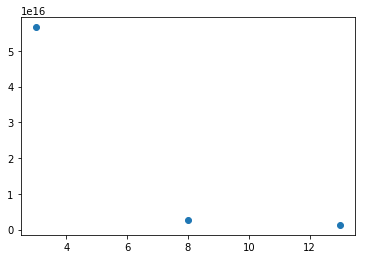

In [168]:
X_cluster = data_filled
k_range = np.arange(3,18,5)
SSE = []
for i in k_range:
    kmeans_model = KMeans(i)
    clusters = kmeans_model.fit_predict(X_cluster)
    SSE.append(kmeans_model.inertia_)
    print(i)

plt.scatter(k_range, SSE)

5
6
7
8
9
10
11


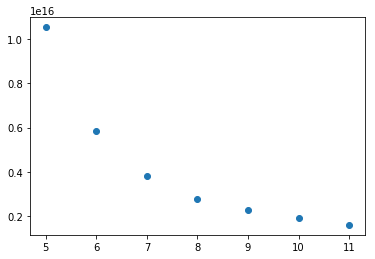

In [169]:
# Elbow point is around k=8. Redo clustering with more precision:
k_range = np.arange(5,12)
SSE = []
for i in k_range:
    kmeans_model = KMeans(i)
    clusters = kmeans_model.fit_predict(data_filled)
    SSE.append(kmeans_model.inertia_)
    print(i)

plt.scatter(k_range, SSE)

In [170]:
# It looks like 6 is the most obvious elbow point. Analysis on K-means clustering with K=6:
kmeans_model = KMeans(6,n_init=30)
clusters = kmeans_model.fit_predict(data_filled)
centroids = pd.DataFrame(kmeans_model.cluster_centers_, columns = data_filled.columns)

In [171]:
display(centroids)

,Current(DC) 1,Current(DC) 10,Current(DC) 11,Current(DC) 12,Current(DC) 13,Current(DC) 14,Current(DC) 15,Current(DC) 16,Current(DC) 2,Current(DC) 3,Current(DC) 4,Current(DC) 5,Current(DC) 6,Current(DC) 7,Current(DC) 8,Current(DC) 9,Efficiency (%) 1,Efficiency (%) 10,Efficiency (%) 11,Efficiency (%) 12,Efficiency (%) 13,Efficiency (%) 14,Efficiency (%) 15,Efficiency (%) 16,Efficiency (%) 2,Efficiency (%) 3,Efficiency (%) 4,Efficiency (%) 5,Efficiency (%) 6,Efficiency (%) 7,Efficiency (%) 8,Efficiency (%) 9,El. Power (W) 1,El. Power (W) 10,El. Power (W) 11,El. Power (W) 12,El. Power (W) 13,El. Power (W) 14,El. Power (W) 15,El. Power (W) 16,El. Power (W) 2,El. Power (W) 3,El. Power (W) 4,El. Power (W) 5,El. Power (W) 6,El. Power (W) 7,El. Power (W) 8,El. Power (W) 9,Motor Run Time (s) 1,Motor Run Time (s) 10,Motor Run Time (s) 11,Motor Run Time (s) 12,Motor Run Time (s) 13,Motor Run Time (s) 14,Motor Run Time (s) 15,Motor Run Time (s) 16,Motor Run Time (s) 2,Motor Run Time (s) 3,Motor Run Time (s) 4,Motor Run Time (s) 5,Motor Run Time (s) 6,Motor Run Time (s) 7,Motor Run Time (s) 8,Motor Run Time (s) 9,Pitch Speed (km/h) 15,Pitch Speed (km/h) 16,Pitch Speed (mph) 1,Pitch Speed (mph) 10,Pitch Speed (mph) 11,Pitch Speed (mph) 12,Pitch Speed (mph) 13,Pitch Speed (mph) 14,Pitch Speed (mph) 15,Pitch Speed (mph) 16,Pitch Speed (mph) 2,Pitch Speed (mph) 3,Pitch Speed (mph) 4,Pitch Speed (mph) 5,Pitch Speed (mph) 6,Pitch Speed (mph) 7,Pitch Speed (mph) 8,Pitch Speed (mph) 9,Ptwist,Spec. Thrust (g/W) 15,Spec. Thrust (g/W) 16,Spec. Thrust (oz/W) 1,Spec. Thrust (oz/W) 10,Spec. Thrust (oz/W) 11,Spec. Thrust (oz/W) 12,Spec. Thrust (oz/W) 13,Spec. Thrust (oz/W) 14,Spec. Thrust (oz/W) 15,Spec. Thrust (oz/W) 16,Spec. Thrust (oz/W) 2,Spec. Thrust (oz/W) 3,Spec. Thrust (oz/W) 4,Spec. Thrust (oz/W) 5,Spec. Thrust (oz/W) 6,Spec. Thrust (oz/W) 7,Spec. Thrust (oz/W) 8,Spec. Thrust (oz/W) 9,Speed (level) (km/h) 15,Speed (level) (km/h) 16,Speed (level) (mph) 1,Speed (level) (mph) 10,Speed (level) (mph) 11,Speed (level) (mph) 12,Speed (level) (mph) 13,Speed (level) (mph) 14,Speed (level) (mph) 15,Speed (level) (mph) 16,Speed (level) (mph) 2,Speed (level) (mph) 3,Speed (level) (mph) 4,Speed (level) (mph) 5,Speed (level) (mph) 6,Speed (level) (mph) 7,Speed (level) (mph) 8,Speed (level) (mph) 9,Throttle(%) 1,Throttle(%) 10,Throttle(%) 11,Throttle(%) 12,Throttle(%) 13,Throttle(%) 14,Throttle(%) 15,Throttle(%) 16,Throttle(%) 2,Throttle(%) 3,Throttle(%) 4,Throttle(%) 5,Throttle(%) 6,Throttle(%) 7,Throttle(%) 8,Throttle(%) 9,Thrust (g) 15,Thrust (g) 16,Thrust (oz) 1,Thrust (oz) 10,Thrust (oz) 11,Thrust (oz) 12,Thrust (oz) 13,Thrust (oz) 14,Thrust (oz) 15,Thrust (oz) 16,Thrust (oz) 2,Thrust (oz) 3,Thrust (oz) 4,Thrust (oz) 5,Thrust (oz) 6,Thrust (oz) 7,Thrust (oz) 8,Thrust (oz) 9,Unnamed: 298,Unnamed: 299,Voltage(DC) 1,Voltage(DC) 10,Voltage(DC) 11,Voltage(DC) 12,Voltage(DC) 13,Voltage(DC) 14,Voltage(DC) 15,Voltage(DC) 16,Voltage(DC) 2,Voltage(DC) 3,Voltage(DC) 4,Voltage(DC) 5,Voltage(DC) 6,Voltage(DC) 7,Voltage(DC) 8,Voltage(DC) 9,inBCcont,inBCellCap,inBP,inBRi,inBS,inBVcell,inBWeight,inEContCurrent,inERi,inEWeight,inGDragCd,inGWeight,inGWingArea,inMIo,inMKv,inMLength,inMLengthInch,inMLimit,inMPoles,inMRi,inMVIo,inMWeight,inMWeightOz,inPConst,inPDiameter,inPPitch,inTConst,outBCapacity,outBCapacityUsed,outBEnergy,outBFlightTime,outBLoad,outBMixedFlightTime,outBRatedVoltage,outBVoltage,outLoggerI,outLoggerP,outLoggerV,outMLevelSpeed,outMRoc,outMStallSpeed,outMVclimbSpeed,outMW3Load,outMWLoad,outMaxEfficiency,outMaxI,outMaxRpm,outMaxTemp,outMaxV,outMaxWin,outMaxWout,outOptEfficiency,outOptI,outOptRpm,outOptV,outOptWin,outOptWout,outPEfficiency,outPFlightThrustOz,outPPitchSpeedMph,outPRpm,outPStallThrust,outPThrust,outPTipSpeed,outTotAUW,outTotDriveWeight,outTotEfficiency,outTotI,outTotPin,outTotPout,outTotPowerWeightWOz,outTotThrustWeight,outTotTorqueLbft,rpm 1,rpm 10,rpm 11,rpm 12,rpm 13,rpm 14,rpm 15,rpm 16,rpm 2,rpm 3,rpm 4,rpm 5,rpm 6,rpm 7,rpm 8,rpm 9,Pitch R

Because of the large number of features, most of the centroid values are difficult to interpret. However, several features yield interesting results. For example, propeller RPM and maximum thrust are both split roughly into three levels, and the levels are distributed throughout the six centroids identically. This would indicate that, in general, optimizing at a higher rpm may result in a higher max thrust. Also, in each of the centroids, an average of only around 85% of the battery capacity is used. It is difficult to determine what factors make this 85% battery capacity use typical, but it is notable that "average" use of battery capacity is 80% while the team's regular use of batteries tries to approach 100% capacity use. Therefore, looking at typical propulsion systems may be ineffective for the team, since the team's use of batteries is vastly different from that in typical propulsion systems.

# K-Means by outputs typically observed by team

3
6
9
12


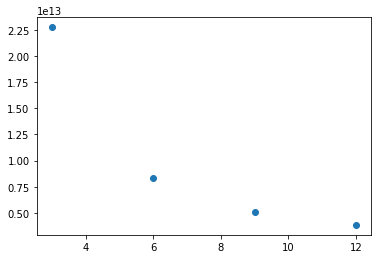

In [176]:
typical_features = data_filled[['outPThrust','outMaxRpm','outMaxI','outMaxV','outMaxEfficiency','outMaxWout','outTotTorqueLbft']]
k_range = np.arange(3,13,3)
SSE = []
for i in k_range:
    kmeans_model = KMeans(i)
    clusters = kmeans_model.fit_predict(typical_features)
    SSE.append(kmeans_model.inertia_)
    print(i)

plt.scatter(k_range, SSE)

4
5
6
7


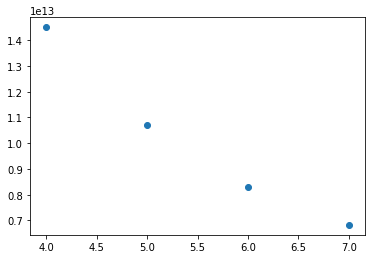

In [177]:
# Elbow point is around k=6. Redo clustering with more precision:
k_range = np.arange(4,8)
SSE = []
for i in k_range:
    kmeans_model = KMeans(i)
    clusters = kmeans_model.fit_predict(typical_features)
    SSE.append(kmeans_model.inertia_)
    print(i)

plt.scatter(k_range, SSE)

In [182]:
# There is no clear elbow point, but 6 looks like the biggest elbow point again. 
# Analysis on K-means clustering with K=6:
kmeans_model = KMeans(6,n_init=50)
clusters = kmeans_model.fit_predict(typical_features)
centroids = pd.DataFrame(kmeans_model.cluster_centers_, columns = typical_features.columns)
display(centroids)

,outPThrust,outMaxRpm,outMaxI,outMaxV,outMaxEfficiency,outMaxWout,outTotTorqueLbft
0,1349.207895,12029.271577,59.714201,17.111346,53.307475,425.698985,0.247364
1,3124.200801,30141.851239,90.751890,35.246289,58.304155,1713.942957,0.402723
2,4379.491945,45407.885901,111.851417,50.059526,58.884762,3014.547660,0.466906
3,2097.473556,19487.480976,75.512874,24.176257,56.299839,885.575884,0.320190
4,703.298579,6221.722845,48.925933,12.020468,42.672779,161.436299,0.334255
5,6985.235814,72481.584564,157.901584,76.384065,56.746555,6579.671835,0.633547


Again, maximum RPM and maximum thrust are closely related; in fact, maximum RPM is consistently around 10 times maximum thrust. However, it is now clear that this relationship may be due to their relationship with current and voltage. So, a more useful observation is that increasing voltage and current greatly increases thrust and rpm; if the team upgrades a propulsion system's voltage or current and those values do not increase, then the team is not even hitting average performance of that voltage and current level. The team may benefit from doing tests with iteratively increasing current and voltage levels in order to further explore the relationship between optimum setup and battery size.
It also appears that maximum efficiency has a positive relationship with current and voltage, which is contrary to some observations that the team made this past year. There are several likely causes of this discrepency, all of which have strong practical implications:

1. If the discrepency is simply due to the high internal resistance of the batteries that the team uses, which the team has found to be a large issue in the past year, then the team can collect more data on the internal resistance of the batteries it uses and incorporate that into the team's predictive models and how the team uses estimators such as eCalc. Running discharge tests would easily determine whether the internal resistance of the team's batteries is misaligned with what the team believes the batteries' internal resistance is.
2. If the discrepency is caused by the team improperly matching propulsion parts, then further analysis can be done, even without more data. This is further explored later in this report.
3. If the discrepency can be attributed to the team's earlier mentioned deviating use of battery capacity, then the team may want to consider finding an optimum percentage of battery capacity to use rather than pushing batteries to 100%. Ideally, the team would change other parts of the propulsion system to match our use of batteries; however, doing so would require an in-depth understanding of the tradeoffs of other parts of the system. So, it would be wiser for the team to first experiment with sizing for different percentages of capacity use (that is, using a 2000mAh battery but sizing for a smaller battery) in order to create a solid baseline to work from. Analysis on battery capacity, which is elaborated on later in this report, suggests that experimentation with battery capacity is valuable regardless of whether it is the cause of the efficiency discrepency between eCalc and the team's test results. So, the team should dedicate time to these tests, and in doing so, determine whether battery capacity usage is the cause of this discrepency.
4. The discrepency may be due to the size of the plane the team flew this year and the fact that eCalc's computations are most likely less accurate as the plane approaches the minimum and maximum possible specifications (such as small size); however, ascertaining this would be very difficult. A large amount of data on different sizes of planes would need to be gathered. Once this is determined, the team will need to then gather even more data in order to generate an accurate translation from common theory's predictions to practical predictions for the team.

# <font size = 50 color = blue> Convenience Functions for Regressions

In [437]:
def get_subset(train_size,test_size,features=None,goal=None,cond=None,args=None):
    if test_size % 1 != 0:
        test_size = int(train_size*test_size)
    if cond == None:
        train_indices = list(np.random.choice(len(data_filled.index),train_size+test_size,replace=False))
    else:
        if args==None:
            condition = lambda index : cond(index)
        else:
            condition = lambda index : cond(index,*args)
        train_indices = []
        goal_len = train_size+test_size
        while (len(train_indices) < goal_len):
            index = np.random.randint(len(data_full))
            if condition(index):
                train_indices.append(index)
    test_indices = [train_indices.pop(random.randrange(len(train_indices))) for _ in range(test_size)]
    if features == None or goal == None:
        return train_indices, test_indices
    else:
        return (data_filled[features].iloc[train_indices],data_filled[features].iloc[test_indices]),
        (data_filled[goal].iloc[train_indices],data_filled[goal].iloc[test_indices])

In [353]:
def Regression_Performance(predict_func,args,testSize,iterations):
    """
    predict_func: function that implements model. must return 3-tuple of rank 1 ndarrays, 
            (_, test true values, test predicted values)
    args: tuple of arguments for predict_func
    testSize: size of test partition, i.e. length of predict_func's outputs
    iterations: number of validation iterations desired 
    """
    cum_stats = np.zeros((3,testSize)) # rows: 0.sum(prediction);  1.sum(prediction^2);  2.sum(pred-real)
    #bias = ( sum(pred - real) )^2 = ( sum(pred) - sum(real) )^2
    #var = sum(pred^2) - sum(pred) ^2
    
    for i in range(iterations):
        (y_true,y_pred,_) = predict_func(args)
        cum_stats[0] += y_pred
        cum_stats[1] += (y_pred - y_true)
        cum_stats[2] += y_pred**2
        
    y_mean_pred = np.sum(cum_stats[0]) / (testSize-1)
    bias = np.sum(cum_stats[1]) / (testSize-1)
    variance = (np.sum(cum_stats[2]) - y_mean_pred^2) / (testSize-1)
    return (y_mean_pred, bias**2 + variance)

# <font size = 50 color = blue> Effects of Pitch and Diameter </font>

In [306]:
data_filled['Pitch Ratio'] = data_filled['inPPitch'] / data_filled['inPDiameter']

In [307]:
filled_corr = data_filled.corr()

In [296]:
pitch_corr = filled_corr['inPPitch'][output_names].dropna().sort_values()
diam_corr = filled_corr['inPDiameter'][output_names].dropna().sort_values()
ratio_corr = filled_corr['Pitch Ratio'][output_names].dropna().sort_values()
display("Pitch")
display(pitch_corr[:5].append(pitch_corr[-5:]))
display("Diameter")
display(diam_corr[:5].append(diam_corr[-5:]))
display("Ratio")
display(ratio_corr[:5].append(ratio_corr[-5:]))

'Pitch'

outPTipSpeed           -0.335852
outPRpm                -0.252215
outMaxRpm              -0.252214
rpm 12                 -0.237976
rpm 1                  -0.237066
Pitch Speed (mph) 6     0.282147
Pitch Speed (mph) 2     0.282150
Pitch Speed (mph) 4     0.282190
Pitch Speed (mph) 12    0.291856
outPPitchSpeedMph       0.307171
Name: inPPitch, dtype: float64

'Diameter'

outMaxEfficiency    -0.546220
outTotEfficiency    -0.518744
Efficiency (%) 11   -0.516243
Throttle(%) 1       -0.510114
Efficiency (%) 12   -0.510008
outTotI              0.254622
outMaxI              0.254625
outLoggerI           0.254629
outTotTorqueLbft     0.265076
Voltage(DC) 12       0.285177
Name: inPDiameter, dtype: float64

'Ratio'

outPTipSpeed           -0.142751
outTotAUW              -0.137564
Voltage(DC) 12         -0.123451
outTotI                -0.119234
outLoggerI             -0.119215
Pitch Speed (mph) 10    0.556665
Pitch Speed (mph) 5     0.556875
Pitch Speed (mph) 2     0.557272
Pitch Speed (mph) 12    0.564527
outPPitchSpeedMph       0.598397
Name: Pitch Ratio, dtype: float64

Pitch:
It appears that increasing pitch increases propeller efficiency and flight time. It also decreases rpm (and therefore tip speed), which is to be expected. The most significant relationship is that maximum torque increases with pitch, since torque is important for matching propulsion system components. Therefore, if a propulsion system is lacking in power, rather than increase battery size (as the team has often done this year), it may be more effective to ensure that the propeller chosen is of optimal pitch. It also confirms that increasing RPM is most likely not the most effective way to generate more thrust in most cases.

Diameter:
Similarly, greaters diameters also correspond with increased propeller efficiency and flight time (as theory would dictate, due to decreases in the effect of airflow at blade tips), as well as lower RPM (also concretely predicted by theory). Similar to pitch, there is also an increase in torque; however, there is also a corresponding increase in voltage and decrease in overall efficiency, which was not seen when increasing pitch. This warrants further investigation.

Pitch Ratio:
It appears that the pitch ratio is closely related to pitch speed; however, pitch speed so far has not been a large issue for the team. Otherwise, the ratio's effects are not immediately obvious.

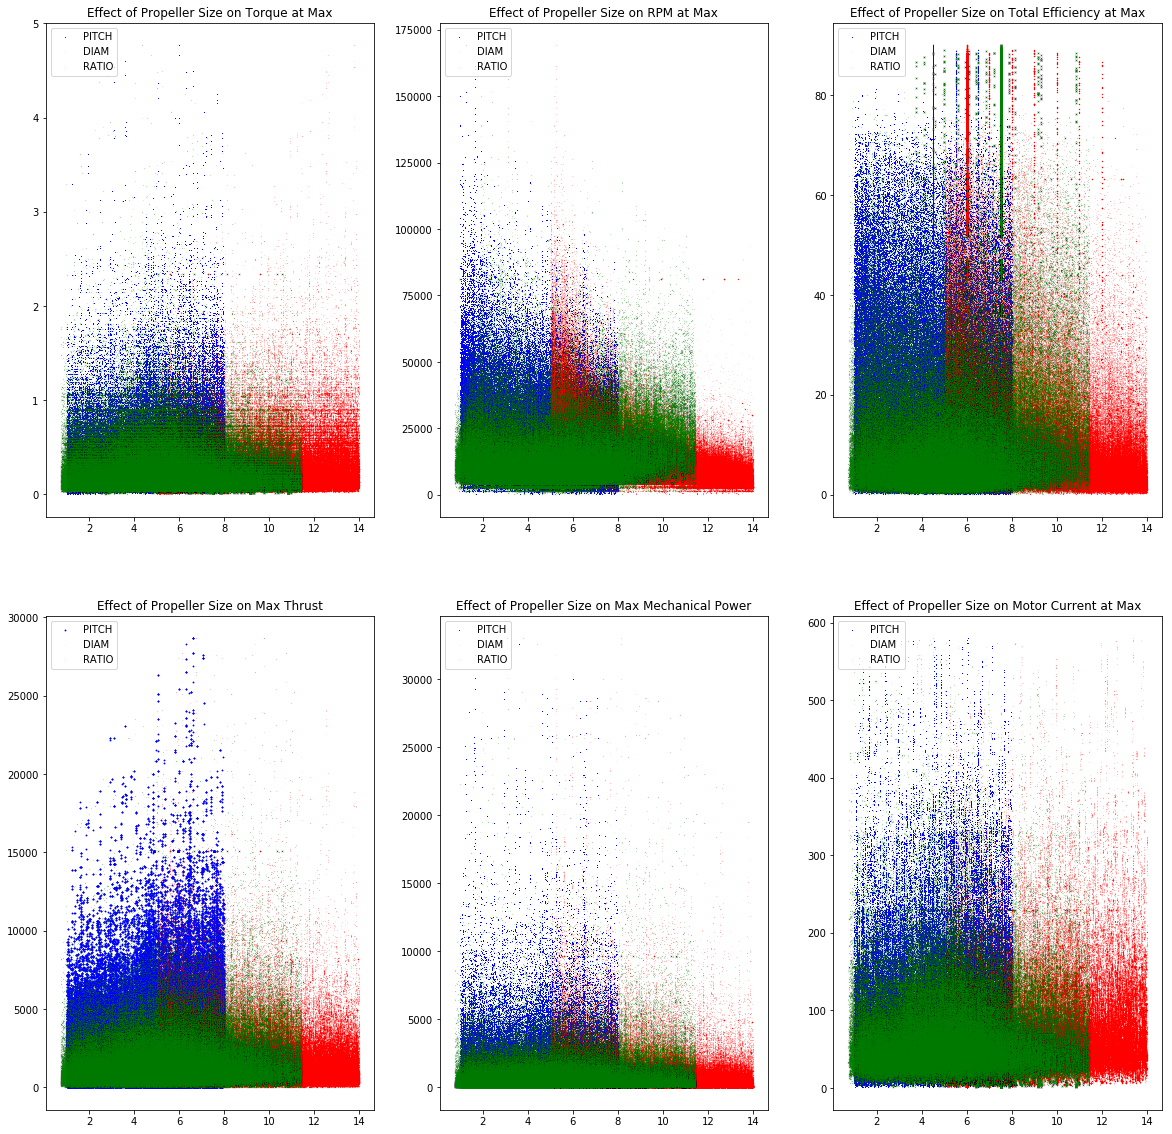

In [308]:
plt.rcParams["figure.figsize"] = (20,20)
f,axes = plt.subplots(2,3)
ratio_data = data_filled[abs(data_filled['Pitch Ratio'] - np.mean(data_filled['Pitch Ratio'])) < 2 * np.std(data_filled['Pitch Ratio'])]
axes[0][0].set_title("Effect of Propeller Size on Torque at Max")
axes[0][0].scatter(data_filled['inPPitch'], data_filled['outTotTorqueLbft'], s=0.001, c='b', marker="*", label='PITCH')
axes[0][0].scatter(data_filled['inPDiameter'], data_filled['outTotTorqueLbft'], s=0.001, c='r', marker="o", label='DIAM')
axes[0][0].scatter(ratio_data['Pitch Ratio']*10, ratio_data['outTotTorqueLbft'], s=0.001, c='g', marker="x", label='RATIO')
axes[0][0].legend(loc='upper left')

axes[0][1].set_title("Effect of Propeller Size on RPM at Max")
axes[0][1].scatter(data_filled['inPPitch'], data_filled['outMaxRpm'], s=0.001, c='b', marker="*", label='PITCH')
axes[0][1].scatter(data_filled['inPDiameter'], data_filled['outMaxRpm'], s=0.001, c='r', marker="o", label='DIAM')
axes[0][1].scatter(ratio_data['Pitch Ratio']*10, ratio_data['outMaxRpm'], s=0.001, c='g', marker="x", label='RATIO')
axes[0][1].legend(loc='upper left')

axes[0][2].set_title("Effect of Propeller Size on Total Efficiency at Max")
axes[0][2].scatter(data_filled['inPPitch'], data_filled['outTotEfficiency'], s=0.001, c='b', marker="*", label='PITCH')
axes[0][2].scatter(data_filled['inPDiameter'], data_filled['outTotEfficiency'], s=0.001, c='r', marker="o", label='DIAM')
axes[0][2].scatter(ratio_data['Pitch Ratio']*10, ratio_data['outTotEfficiency'], s=0.001, c='g', marker="x", label='RATIO')
axes[0][2].legend(loc='upper left')

axes[1][0].set_title("Effect of Propeller Size on Max Thrust")
axes[1][0].scatter(data_filled['inPPitch'], data_filled['outPThrust'], s=1, c='b', marker="*", label='PITCH')
axes[1][0].scatter(data_filled['inPDiameter'], data_filled['outPThrust'], s=0.001, c='r', marker="o", label='DIAM')
axes[1][0].scatter(ratio_data['Pitch Ratio']*10, ratio_data['outPThrust'], s=0.001, c='g', marker="x", label='RATIO')
axes[1][0].legend(loc='upper left')

axes[1][1].set_title("Effect of Propeller Size on Max Mechanical Power")
axes[1][1].scatter(data_filled['inPPitch'], data_filled['outMaxWout'], s=0.001, c='b', marker="*", label='PITCH')
axes[1][1].scatter(data_filled['inPDiameter'], data_filled['outMaxWout'], s=0.001, c='r', marker="o", label='DIAM')
axes[1][1].scatter(ratio_data['Pitch Ratio']*10, ratio_data['outMaxWout'], s=0.001, c='g', marker="x", label='RATIO')
axes[1][1].legend(loc='upper left')

axes[1][2].set_title("Effect of Propeller Size on Motor Current at Max")
axes[1][2].scatter(data_filled['inPPitch'], data_filled['outMaxI'], s=0.001, c='b', marker="*", label='PITCH')
axes[1][2].scatter(data_filled['inPDiameter'], data_filled['outMaxI'], s=0.001, c='r', marker="o", label='DIAM')
axes[1][2].scatter(ratio_data['Pitch Ratio']*10, ratio_data['outMaxI'], s=0.001, c='g', marker="x", label='RATIO')
axes[1][2].legend(loc='upper left')
plt.show()
plt.rcParams["figure.figsize"] = (16,3)

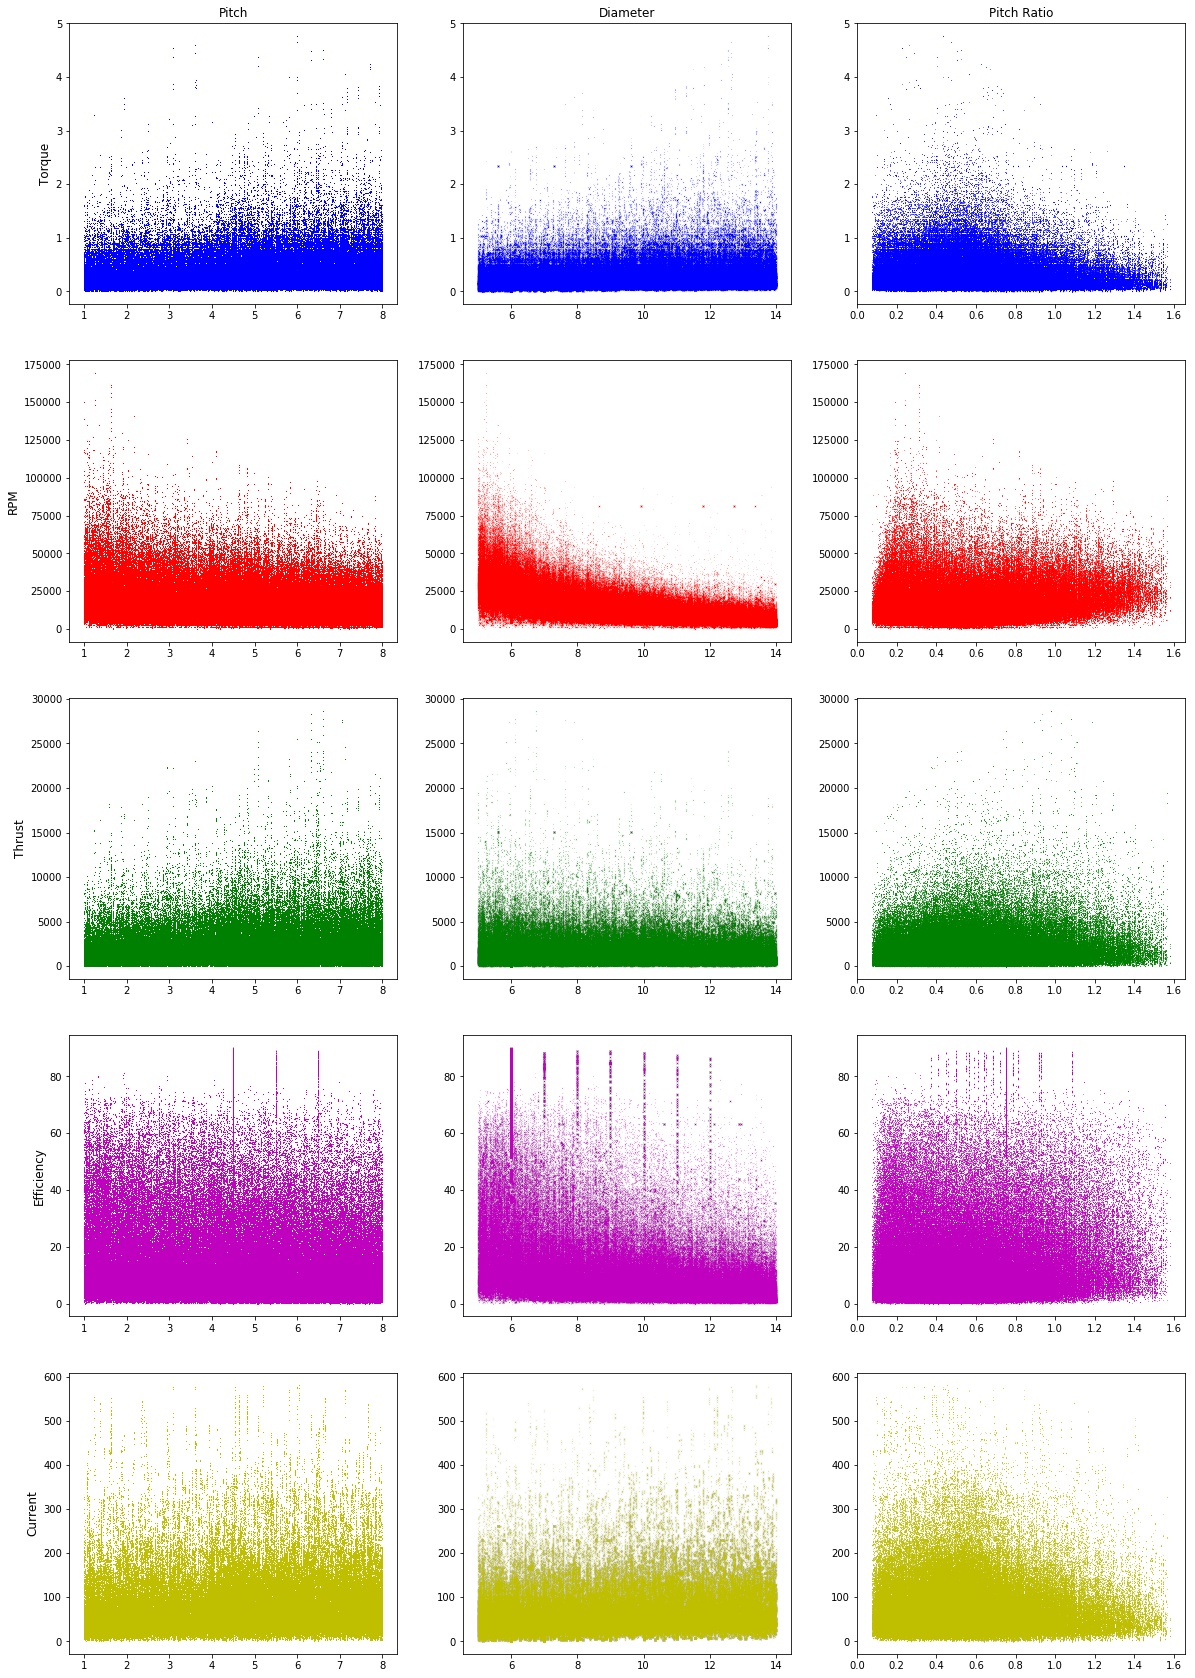

In [319]:
plt.rcParams["figure.figsize"] = (20,30)
f,axes = plt.subplots(5,3)#,sharex = 'col', sharey = 'row')
ratio_data = data_filled[abs(data_filled['Pitch Ratio'] - np.mean(data_filled['Pitch Ratio'])) < 2 * np.std(data_filled['Pitch Ratio'])]

axes[0][0].set_title('Pitch',size='large')
axes[0][1].set_title('Diameter',size='large')
axes[0][2].set_title('Pitch Ratio',size='large')

axes[0][0].set_ylabel('Torque', size='large')
axes[1][0].set_ylabel('RPM', size='large')
axes[2][0].set_ylabel('Thrust', size='large')
axes[3][0].set_ylabel('Efficiency', size='large')
axes[4][0].set_ylabel('Current', size='large')

axes[0][0].scatter(data_filled['inPPitch'], data_filled['outTotTorqueLbft'], s=0.001, c='b', marker="*", label='Torque')
axes[1][0].scatter(data_filled['inPPitch'], data_filled['outMaxRpm'], s=0.001, c='r', marker="*", label='RPM')
axes[2][0].scatter(data_filled['inPPitch'], data_filled['outPThrust'], s=0.001, c='g', marker="*", label='Thrust')
axes[3][0].scatter(data_filled['inPPitch'], data_filled['outTotEfficiency'], s=0.001, c='m', marker="*", label='Efficiency')
axes[4][0].scatter(data_filled['inPPitch'], data_filled['outMaxI'], s=0.001, c='y', marker="*", label='Current')

axes[0][1].scatter(data_filled['inPDiameter'], data_filled['outTotTorqueLbft'], s=0.001, c='b', marker="x", label='Torque')
axes[1][1].scatter(data_filled['inPDiameter'], data_filled['outMaxRpm'], s=0.001, c='r', marker="x", label='RPM')
axes[2][1].scatter(data_filled['inPDiameter'], data_filled['outPThrust'], s=0.001, c='g', marker="x", label='Thrust')
axes[3][1].scatter(data_filled['inPDiameter'], data_filled['outTotEfficiency'], s=0.001, c='m', marker="x", label='Efficiency')
axes[4][1].scatter(data_filled['inPDiameter'], data_filled['outMaxI'], s=0.001, c='y', marker="x", label='Current')

axes[0][2].scatter(data_filled['Pitch Ratio'], data_filled['outTotTorqueLbft'], s=0.001, c='b', marker="^", label='Torque')
axes[1][2].scatter(data_filled['Pitch Ratio'], data_filled['outMaxRpm'], s=0.001, c='r', marker="^", label='RPM')
axes[2][2].scatter(data_filled['Pitch Ratio'], data_filled['outPThrust'], s=0.001, c='g', marker="^", label='Thrust')
axes[3][2].scatter(data_filled['Pitch Ratio'], data_filled['outTotEfficiency'], s=0.001, c='m', marker="^", label='Efficiency')
axes[4][2].scatter(data_filled['Pitch Ratio'], data_filled['outMaxI'], s=0.001, c='y', marker="^", label='Current')




plt.show()

At both high diameters as well as at high pitch ratios, efficiency approaches 0. This means that for a constant pitch, the optimal diameter is the one that balances the inefficiencies of low diameter and high diameter. Also, current decreases as pitch ratio increases. This indicates that with larger pitch ratios, a greater voltage (and thus a larger battery pack) may be needed; however, at larger diameters, efficiency and RPM decrease. Therefore, for a given pitch, there exists an optimization problem between diameter and battery size. This can explain the peak in the torque and thrust graphs for pitch ratio, which peak at a pitch ratio of between 0.4 and 0.6, gradually tapering off on below 0.4 while steeply declining above 0.6. 

It is notable that there are a few points in the high pitch ratio range with just as high thrust as the middle pitch ratio range, and a few points in the low pitch ratio range with just as high torque as the middle pitch ratio range. These may be optimal points in certain situations, but the sparsity of those points indicates that the systems that reach those points may not be stable enough to be put into practice.

The relationship described above yields an algorithm for choosing diameter and battery size given a pitch and motor: starting from a large diameter, decrease diameter and increase battery size until a peak thrust is reached. The issue, then, is how to choose pitch. Torque and thrust appear to increase slightly with pitch; however, there also is a small peak between 4 and 5 inches. This reflects the effects of pitch ratio: torque would increase as pitch increased, but since the pitch diameter was bound above, pitches above 5 inches could not achieve optimal pitch ratios, and so the torque failed to increase as much with pitches greater than 5 inches. Therefore, the underlying relationship is that torque and thrust both increase as pitch increases. Therefore, the optimal pitch is the highest pitch possible, bounded above by the pitch ratio relationships described earlier. This means that diameter is bounded by pitch and pitch is bounded by diameter; therefore, this problem is most easily solved by iterating through different pitches, finding the optimal diameter for each pitch, and choosing the best option out of these semi-optimal pitch-diameter pairings.

This algorithm requires machine learning on test data in order to find an accurate relationship between the control parameters (pitch, pitch ratio, diameter, and battery cells) and the outputs (thrust, torque, necessary current, etc.).

The weakness of this algorithm, however, is that it does not take into account the motor itself. With this algorithm, a Kv would be chosen given the found optimal point, and then a motor with that Kv would be selected; however, there exist important relationships that involve Kv, weight, and motor internal resistance. So, an improved algorithm would use a different variable as the primary variable to iterate through, use that variable to predict the tradeoffs between motor weight, Kv, and internal resistance, and then use the concepts discussed above to find the optimal points.

# <font size = 50 color = blue> Regression Model for Thrust  </font>

In [354]:
train_indices, test_indices = get_subset(300000,0.3)
scores = []
thrust_goal = data_filled['outPThrust']
for alpha in [0.3,0.5,0.6,0.7,0.8,0.9,1,1.2]:
    thrust_lasso = Lasso(alpha=alpha,max_iter=5000)
    thrust_lasso.fit(inputs_filled.iloc[train_indices],thrust_goal.iloc[train_indices])
    SSE = mean_squared_error(thrust_goal.iloc[test_indices],thrust_lasso.predict(inputs_filled.iloc[test_indices]))
    score = r2_score(thrust_goal.iloc[test_indices],thrust_lasso.predict(inputs_filled.iloc[test_indices]))
    scores.append((alpha,SSE,score))

In [355]:
display(scores)

[(0.3, 2353109.2922159955, 0.19988513265811825),
 (0.5, 2353950.1043487536, 0.19959923591278372),
 (0.6, 2354568.107093771, 0.19938909982349018),
 (0.7, 2355317.841156592, 0.19913417185554572),
 (0.8, 2356199.3065266986, 0.1988344520125268),
 (0.9, 2356748.7577383853, 0.19864762512573342),
 (1, 2357092.92305133, 0.19853060047897297),
 (1.2, 2357909.7647890635, 0.19825285425580008)]

In [367]:
thrust_lasso = Lasso(alpha=1,max_iter=5000)
thrust_lasso.fit(inputs_filled.iloc[train_indices],thrust_goal.iloc[train_indices])
print('Weights given to each feature: ')
print(pd.Series(thrust_lasso.coef_, index = input_names))

Weights given to each feature: 
inBS                22.154686
inBCellCap           0.054621
inBRi            -1074.206273
inEContCurrent       0.325890
inERi            -3322.490103
inMKv               -0.090245
inMIo              336.047005
inMVIo              -1.186432
inMLimit             0.078906
inMRi            -1027.893885
inPDiameter         -0.511454
inPPitch            49.249481
Ptwist              -8.018258
inGWeight            0.022484
inMPoles            -4.544113
inGWingArea         -0.029430
inGDragCd           -0.000000
inPConst         -1253.510321
inTConst          1867.925759
inBVcell           110.492451
inBP               612.830444
inBCcont             3.677598
dtype: float64


It appears that the resistances are dominating the regression, which is accurate but not necessarily useful for the team, since battery, ESC, and motor resistances do not vary much when the team is choosing a propulsion system. Redoing the lasso regression with only quantitative propulsion features for which values were changed frequently:

In [438]:
train_indices, test_indices = get_subset(300000,0.3)
SSE_scores = []
r2_scores = []
thrust_goal = data_filled['outPThrust']
features_list = []
for r in range(1,len(no_limit_quantitative_input_names)):
    feature_name_combos = itertools.combinations(no_limit_quantitative_input_names,r)
    for feature_combo in feature_name_combos:
        features = data_filled[[*feature_combo]]
        temp_SSE = []
        temp_r2 = []
        for alpha in [0.3,0.5,0.6,0.7,0.8,0.9,1,1.2]:
            thrust_lasso = Lasso(alpha=alpha,max_iter=5000)
            thrust_lasso.fit(features.iloc[train_indices],thrust_goal.iloc[train_indices])
            temp_SSE.append(mean_squared_error(thrust_goal.iloc[test_indices],
                                                  thrust_lasso.predict(features.iloc[test_indices])))
            temp_r2.append(r2_score(thrust_goal.iloc[test_indices],
                                                  thrust_lasso.predict(features.iloc[test_indices])))
        SSE_scores.append(min(temp_SSE))
        r2_scores.append(max(temp_r2))
        features_list.append(feature_combo)

In [439]:
SSE_copy = SSE_scores.copy()
best_5 = []
for _ in range(5):
    i = np.argmin(SSE_copy)
    best_5.append((features_list[i],SSE_copy.pop(i)))
for i in best_5:
    print(i)
r2_copy = r2_scores.copy()
print('')
best_5_r2 = []
for _ in range(5):
    i = np.argmax(r2_copy)
    best_5_r2.append((features_list[i],r2_copy.pop(i)))
for i in best_5_r2:
    print(i)

(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2613374.858034943)
(('inERi', 'inPDiameter', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2622571.1598212416)
(('inERi', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2623590.044593239)
(('inERi', 'inPDiameter', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap'), 2628644.435852866)
(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBRi'), 2629992.2565376116)

(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.10333466823712556)
(('inERi', 'inPDiameter', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.10017935932043875)
(('inERi', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.09982977355423983)
(('inERi', 'inPDiameter', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap'), 0.09809558015992503)
(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBRi'), 0.0976331344155923)


It seems that the biggest factors are resistance (of ESC, motor, and battery), motor Kv, cell capacity, number of battery cells, and propeller pitch and diameter. 

In [441]:
# Calculate relative error of this regression:
# (avg abs error) / (avg Thrust), where (avg abs error) = sqrt(SSE / number of samples)
rel_error = np.sqrt(2613374.858034943/(300000*0.3)) / np.mean(data_filled['outPThrust'])
print(rel_error)

0.003405807782482648


From a simple regression using close to no intuition, nearly no data analysis by hand, and without feature engineering, the relative error is under 1%. The fact that no feature engineering was needed is especially encouraging, since the Lasso model was able to regress accurately without being able to take any features to a power; therefore, if the parameters of the train data and the test data do not deviate by too much, the Lasso model is very forgiving. When creating models based on the team's real data, more rigor will be required for identifying and dealing with outliers and engineering new features. To check, reproduce the experiment with 1000 sample points:

In [442]:
train_indices, test_indices = get_subset(500,100000)
SSE_scores = []
r2_scores = []
thrust_goal = data_filled['outPThrust']
features_list = []
for r in range(1,len(no_limit_quantitative_input_names)):
    feature_name_combos = itertools.combinations(no_limit_quantitative_input_names,r)
    for feature_combo in feature_name_combos:
        features = data_filled[[*feature_combo]]
        temp_SSE = []
        temp_r2 = []
        for alpha in [0.3,0.5,0.6,0.7,0.8,0.9,1,1.2]:
            thrust_lasso = Lasso(alpha=alpha,max_iter=5000)
            thrust_lasso.fit(features.iloc[train_indices],thrust_goal.iloc[train_indices])
            temp_SSE.append(mean_squared_error(thrust_goal.iloc[test_indices],
                                                  thrust_lasso.predict(features.iloc[test_indices])))
            temp_r2.append(r2_score(thrust_goal.iloc[test_indices],
                                                  thrust_lasso.predict(features.iloc[test_indices])))
        SSE_scores.append(min(temp_SSE))
        r2_scores.append(max(temp_r2))
        features_list.append(feature_combo)

In [443]:
SSE_copy = SSE_scores.copy()
best_5 = []
for _ in range(5):
    i = np.argmin(SSE_copy)
    best_5.append((features_list[i],SSE_copy.pop(i)))
for i in best_5:
    print(i)
r2_copy = r2_scores.copy()
print('')
best_5_r2 = []
for _ in range(5):
    i = np.argmax(r2_copy)
    best_5_r2.append((features_list[i],r2_copy.pop(i)))
for i in best_5_r2:
    print(i)

(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2657304.5669371295)
(('inERi', 'inPDiameter', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2660059.20816991)
(('inERi', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2661287.9648873536)
(('inERi', 'inPDiameter', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap'), 2662080.625330031)
(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBRi'), 2663727.78535022)

(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.09241933119130108)
(('inERi', 'inPDiameter', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.09147850597936202)
(('inERi', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.09105883415954275)
(('inERi', 'inPDiameter', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap'), 0.09078810746014432)
(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBRi'), 0.09022553340997408)


In [444]:
# Calculate relative error of this regression:
# (avg abs error) / (avg Thrust), where (avg abs error) = sqrt(SSE / number of samples)
rel_error = np.sqrt(2657304.5669371295/(100000)) / np.mean(data_filled['outPThrust'])
print(rel_error)

0.003258075926208485


In [445]:
train_indices, test_indices = get_subset(200,10000)
SSE_scores = []
r2_scores = []
thrust_goal = data_filled['outPThrust']
features_list = []
for r in range(1,len(no_limit_quantitative_input_names)):
    feature_name_combos = itertools.combinations(no_limit_quantitative_input_names,r)
    for feature_combo in feature_name_combos:
        features = data_filled[[*feature_combo]]
        temp_SSE = []
        temp_r2 = []
        for alpha in [0.3,0.5,0.6,0.7,0.8,0.9,1,1.2]:
            thrust_lasso = Lasso(alpha=alpha,max_iter=5000)
            thrust_lasso.fit(features.iloc[train_indices],thrust_goal.iloc[train_indices])
            temp_SSE.append(mean_squared_error(thrust_goal.iloc[test_indices],
                                                  thrust_lasso.predict(features.iloc[test_indices])))
            temp_r2.append(r2_score(thrust_goal.iloc[test_indices],
                                                  thrust_lasso.predict(features.iloc[test_indices])))
        SSE_scores.append(min(temp_SSE))
        r2_scores.append(max(temp_r2))
        features_list.append(feature_combo)

In [446]:
SSE_copy = SSE_scores.copy()
best_5 = []
for _ in range(5):
    i = np.argmin(SSE_copy)
    best_5.append((features_list[i],SSE_copy.pop(i)))
for i in best_5:
    print(i)
r2_copy = r2_scores.copy()
print('')
best_5_r2 = []
for _ in range(5):
    i = np.argmax(r2_copy)
    best_5_r2.append((features_list[i],r2_copy.pop(i)))
for i in best_5_r2:
    print(i)

(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2745434.6229817146)
(('inERi', 'inPDiameter', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2751217.840674837)
(('inERi', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 2752272.137495121)
(('inERi', 'inPDiameter', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBRi'), 2756061.082323819)
(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBCellCap', 'inBRi'), 2756765.7419259963)

(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.07652861618560025)
(('inERi', 'inPDiameter', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.0745833372846707)
(('inERi', 'inMKv', 'inMRi', 'inBS', 'inBCellCap', 'inBRi'), 0.07422870748018418)
(('inERi', 'inPDiameter', 'inPPitch', 'inMKv', 'inMRi', 'inBS', 'inBRi'), 0.07295423454432748)
(('inERi', 'inPPitch', 'inMKv', 'inMRi', 'inBCellCap', 'inBRi'), 0.0727172108787506)


In [447]:
# Calculate relative error of this regression:
# (avg abs error) / (avg Thrust), where (avg abs error) = sqrt(SSE / number of samples)
rel_error = np.sqrt(2745434.6229817146/(10000)) / np.mean(data_filled['outPThrust'])
print(rel_error)

0.010472396746437683


With 500 train samples and 100,000 test samples, the relative error is under 1%. With 200 train samples and 10,000 test samples, the relative error is still barely over 1%.

# <font size = 50 color = blue> eCalc Error Analysis  </font>

This section will try to develop models for predicting the error between the team's test data and eCalc's data. Because the team does not have much data, these models will most likely be too overfitted for accurate use and therefore require refinement as the team collects more data.

# Data import and Cleaning #

In [387]:
dataFile = pd.read_csv("Copy of Propulsion System Database.csv")
data = pd.DataFrame(dataFile)

data = data.rename(columns={'Volt':'MotorVolt'})

# remove useless rows
data = data[pd.notnull(data['Prop'])]

# create useful rows
data['Diam'], data['Pitch'] = data['Prop'].str.split('x', 1).str
data = data[data['ThrustMax'].notnull() | data['ThrustSteady'].notnull()]
data.drop(columns=['Prop'], inplace=True)
data['BattVolt'] = data['BattCells'] * 1.3 # 1.3 used instead of 1.2 because we normally use batteries from full charge
data.drop(columns=['BattCells'],inplace=True)

# fill in NaN values
data['Motor'].fillna(0,inplace=True)
dataOmit = (data.copy()).fillna(0) # dataframe with 0 replacing all missing values so that missing values can be identified
data[data.columns.drop('Motor')] = data.drop(columns=['Motor']).apply(pd.to_numeric,errors='coerce')
for col in ['MotorWgt','TotalWgt','MotorVolt','Current','EPower','RPM','KV']:
    data[col].fillna(str((data[col].astype(float).fillna(0.0)).mean()),inplace=True)
for col in ['BattCapacity','NumPoles','Diam','Pitch']:
    data[col].fillna(str(data[col].median()),inplace=True)
data['Throttle'].fillna(100,inplace=True)
data.fillna(0,inplace=True)

# convert all columns to floats
enc = LabelEncoder()
data['Motor'] = enc.fit_transform(data['Motor'])
data = (data.apply(pd.to_numeric))

data['RE_EPower'] = (data['ECEPower'] - data['EPower']) / data['ECEPower']
data['RE_Thrust'] = (data['ECThrust'] - data['ThrustMax']) / data['ECThrust']
#RE_RPM and RE_Duration not included because we currently do not have enough RPM measures
data['RE_Current'] = (data['ECCurrent'] - data['Current']) / data['ECCurrent']
data.fillna(0,inplace=True)

# Correlation Analysis

In [388]:
RE_Names = ['RE_EPower','RE_Thrust','RE_Current']
printmd('### Correlation Overview')
print()
for RE_name in RE_Names:
    printmd('**'+RE_name+' Correlation**')
    corr = (data.corr())[RE_name]
    corr.drop(RE_name, inplace=True)
    display(corr[corr>0.4])
    print(corr[corr<-0.4])
    print('\n\n\n')

### Correlation Overview

**RE_EPower Correlation**

Throttle      0.415221
RE_Thrust     0.613142
RE_Current    0.974300
Name: RE_EPower, dtype: float64

ECDuration   -0.673544
Name: RE_EPower, dtype: float64






**RE_Thrust Correlation**

RE_EPower     0.613142
RE_Current    0.581334
Name: RE_Thrust, dtype: float64

ECDuration   -0.648605
Name: RE_Thrust, dtype: float64






**RE_Current Correlation**

RE_EPower    0.974300
RE_Thrust    0.581334
Name: RE_Current, dtype: float64

ECDuration   -0.606273
Name: RE_Current, dtype: float64






In [389]:
printmd('### RE_Power Correlation')
RE_Power_data = pd.DataFrame(data['RE_EPower'],dtype = float)
for col in ['KV','BattVolt','BattCapacity','MotorWgt','TotalWgt','NumPoles','MotorVolt','ThrustMax'
            ,'Diam','Pitch']:
    temp = pd.DataFrame(data['RE_EPower'],dtype = float)
    temp[col+'_INV'] = 1 / data[col]
    temp[col+'_INVSQ'] = temp[col+'_INV']**2
    temp[col+'_INVCUBE'] = temp[col+'_INV']**3
    temp[col+'_SQ'] = data[col] ** 2
    temp[col+'_CUBE'] = data[col] ** 3
    temp[col+'_POW'] = (data[col]/10).apply(math.exp)
    for i in np.arange(0,max(data[col])*2,max(data[col])/100):
        temp[col+'_NON-NEG'] = data[col] + i
        if ((data[col] > 0).all()):
            temp[col+'_LOG' + str(i)] = (data[col] + i).apply(math.log)
    Col_Name_Best = (temp.corr()['RE_EPower'].drop('RE_EPower')).idxmax()
    RE_Power_data[Col_Name_Best] = temp[Col_Name_Best]
with pd.option_context('display.max_rows', None):
    print((((RE_Power_data.corr())['RE_EPower'].drop(['RE_EPower'])).sort_values()).apply(lambda x: '%.2f' %x))

### RE_Power Correlation

MotorVolt_INV        0.02
MotorWgt_LOG0.0      0.04
TotalWgt_LOG0.0      0.05
BattVolt_NON-NEG     0.05
KV_INV               0.07
BattCapacity_INV     0.16
NumPoles_CUBE        0.19
ThrustMax_NON-NEG    0.20
Pitch_LOG0.0         0.24
Diam_LOG0.0          0.28
Name: RE_EPower, dtype: object


In [390]:
def LinReg_Prediction(features,target,random_state=None):
    if random_state == None:
        train_features, valid_features, train_target, valid_target = train_test_split(
                features, target, test_size=0.5)
    else:
        train_features, valid_features, train_target, valid_target = train_test_split(
                features, target, test_size=0.5, random_state= random_state) 
    
    model = LinearRegression()
    model = model.fit(train_features, train_target)

    # predict on validations using the validation features as input
    valid_predictions = model.predict(valid_features)
    all_predictions = model.predict(features)
    
    return (valid_target, valid_predictions, all_predictions)

In [408]:
printmd('### RE_Power Predictions with One-Feature Linear Regressions')
RE_Power_LinReg_Pred = []
for col in ['KV','BattVolt','BattCapacity','MotorWgt','TotalWgt','NumPoles','MotorVolt','ThrustMax'
            ,'Diam','Pitch']:
    temp = pd.DataFrame(dtype = float)
    temp[col+'_SQ'] = data[col] ** 2
    if ((data[col] != 0).all()):
        temp[col+'_INV'] = 1 / data[col]
        temp[col+'_INVSQ'] = temp[col+'_INV']**2
        temp[col+'_INVCUBE'] = temp[col+'_INV']**3
    temp[col+'_CUBE'] = data[col] ** 3
    temp[col+'_POW'] = (data[col]/10).apply(math.exp)
    for i in np.arange(0,max(data[col])*2,max(data[col])/10):
        temp[col+'_NON-NEG'] = data[col] + i
        if ((data[col] > 0).all()):
            temp[col+'_LOG' + str(i)] = (data[col] + i).apply(math.log)
    tempLinRegs = pd.DataFrame(index = data.index, dtype = float)
    for i in temp.columns:
        tempLinRegs[i] = LinReg_Prediction(temp[i].reshape(-1, 1),data['RE_EPower'].reshape(-1, 1))[2]
    errors = [mean_squared_error(*LinReg_Prediction(temp[col].values.reshape(-1,1),data['RE_EPower'])[0:2])
                                 for col in tempLinRegs.columns]
    i = np.argmin(errors)
    RE_Power_LinReg_Pred.append(((tempLinRegs.columns)[i], errors[i]))
    
with pd.option_context('display.max_rows', None):
    display(RE_Power_LinReg_Pred)

### RE_Power Predictions with One-Feature Linear Regressions

/Users/dylantsai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


[('KV_INVSQ', 0.6535917885887671),
 ('BattVolt_POW', 0.6765486806343242),
 ('BattCapacity_LOG1760.0', 0.7741647623954835),
 ('MotorWgt_LOG0.34199999999999997', 0.8563670983145274),
 ('TotalWgt_LOG1.9209999999999998', 0.574930630875274),
 ('NumPoles_POW', 0.6062011430043582),
 ('MotorVolt_POW', 0.7249264122847061),
 ('ThrustMax_NON-NEG', 1.2358347961123326),
 ('Diam_LOG12.0', 0.7315868205111108),
 ('Pitch_INVSQ', 0.8363243415669962)]

The most accurate model uses the total weight, with a total sum of square error of 0.5749. This is an extremely inaccurate model, but it indicates that the discrepency between eCalc results and test data is highly related to the size of the propulsion system. This test does not determine whether the cause of this relationship is eCalc's predictions being less accurate on smaller scales or a systematic error in the team's tests on smaller systems; more data will need to be collected.